In [2]:
from binance import Client
import pandas as pd
import time
from itertools import count
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import requests
import math

import tensorflow as tf
from tensorflow import keras
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import pandas_datareader.data as web
import datetime
import seaborn as sns
plt.style.use('ggplot')
secret_pharse = ""
API_key = ""

client= Client(API_key,secret_pharse)

# Fonctions to get data

In [10]:
Tickers=["XTZUSDT","XRPUSDT","BNBUSDT","ETHUSDT","XMRUSDT","LTCUSDT","ADAUSDT","DOGEUSDT","DOTUSDT","AVAXUSDT","MATICUSDT","LINKUSDT","BTCUSDT","VETUSDT","KSMUSDT"] 

class data :
    
    def price_token(self,pair):
        global df
        tickers = client.get_all_tickers()
        df_tickers = pd.DataFrame(tickers)
        df_tickers.set_index("symbol",inplace=True)

        df=df_tickers.loc[str(pair)].iloc[0]
        return float(df)

    def bid_ask_wall(self,pair):
        global df_wall_ask, df_wall_bid
        bloc = client.get_order_book(symbol=pair)
        df_wall_ask = pd.DataFrame(bloc["asks"])
        df_wall_ask.columns = ["Ask","Volume"]
        df_wall_bid = pd.DataFrame(bloc["bids"])
        df_wall_bid.columns =["Bid","Volume"]
        bid_ask_df =pd.concat([df_wall_bid,df_wall_ask], axis=1)
        bid_ask_df=bid_ask_df.astype(float)
        bid_ask_df["Spread"] = bid_ask_df["Ask"] - bid_ask_df["Bid"]
        bid_ask_df["Mid_point"] = (bid_ask_df["Ask"] + bid_ask_df["Bid"])/2
        bid_ask_df["Relative_Spread"] = bid_ask_df["Spread"] /  bid_ask_df["Mid_point"]
        return bid_ask_df.iloc[0]

    def get_stocks_data(self,start,end):
        global SP500,dow_jones,nasdaq
        SP500 = web.DataReader(['^GSPC'], 'yahoo', start, end)
        SP500 = SP500.fillna(SP500["Close"].rolling(window=3).mean())
        SP500 = SP500["Close"]
        SP500 = SP500.rename(columns={'^GSPC':"Close_S&P500"})
        SP500 = SP500.iloc[:,0]
        dow_jones = web.DataReader(['^DJI'], 'yahoo', start, end)
        dow_jones = dow_jones.fillna(dow_jones["Close"].rolling(window=3).mean())
        dow_jones = dow_jones["Close"]
        dow_jones = dow_jones.rename(columns={'^DJI':"Close dow_jones"})
        dow_jones = dow_jones.iloc[:,0]
        nasdaq = web.DataReader(['^IXIC'], 'yahoo', start, end)
        nasdaq = nasdaq.fillna(nasdaq["Close"].rolling(window=3).mean())
        nasdaq = nasdaq["Close"]
        nasdaq = nasdaq.rename(columns={'^IXIC':"Close_Nasdaq"})
        nasdaq=nasdaq.iloc[:,0]


    def get_historical_data(self,pair,start_date,timeframe,log_returns=False):
        global df_historical_data
        command = "Client.KLINE_INTERVAL_{}".format(timeframe)
        historical_data = client.get_historical_klines(str(pair),eval(command),str(start_date))
        df_historical_data = pd.DataFrame(historical_data)
        df_historical_data.columns =  ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                        'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
        df_historical_data['Open Time'] = pd.to_datetime(df_historical_data['Open Time']/1000, unit='s')
        df_historical_data['Close Time'] = pd.to_datetime(df_historical_data['Close Time']/1000, unit='s')
        df_historical_data = df_historical_data[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of Trades']]
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Number of Trades']
        df_historical_data[numeric_columns]=df_historical_data[numeric_columns].apply(pd.to_numeric, axis=1)
        df_historical_data["Simple_returns"] = df_historical_data["Close"].pct_change()
        df_historical_data.set_index("Open Time", inplace =True)

        if log_returns == True:
            df_historical_data["log_returns"] = [np.log(rt +1) for rt in  df_historical_data["Simple_returns"]]

        return df_historical_data

    def multiple_historical_data(self,Tickers,start_date,timeframe):
        global data
        df={}
        data = pd.DataFrame()
        for ticker in Tickers:
            df[f"{ticker}"]= self.get_historical_data(ticker,start_date,timeframe)
            df[f"{ticker}"] = df_historical_data["Close"]
            data[f"{ticker}"]=df[f"{ticker}"]
        check_for_nan = data.isnull().sum()
        print("NaN values found:")
        print(check_for_nan)
        data = data.dropna(axis=0)
        data=data.sort_values(by="Open Time")

    def denormalize(mean,std,data):
        return (data*std)+mean

    def parse_na_values(df_column):
        for i in range(len(df_column)):
            if np.isnan(df_column[i]):
                df_column[i]=df_column[i-1]


In [11]:
data = data()
data.get_historical_data("BTCUSDT","01-01-2020","4HOUR",log_returns=False)

,Open,High,Low,Close,Volume,Number of Trades,Simple_returns
Open Time,,,,,,,
2020-01-01 00:00:00,7195.24,7245.00,7175.46,7225.01,2833.749180,32476.0,NaN
2020-01-01 04:00:00,7225.00,7236.27,7199.11,7209.83,2061.295051,29991.0,-0.002101
2020-01-01 08:00:00,7209.83,7237.73,7180.00,7197.20,3166.654361,33507.0,-0.001752
2020-01-01 12:00:00,7197.20,7255.00,7196.15,7234.19,3492.537459,36549.0,0.005139
2020-01-01 16:00:00,7234.20,7249.99,7214.00,7229.48,2980.583291,32877.0,-0.000651
...,...,...,...,...,...,...,...
2023-04-23 20:00:00,27465.78,27650.28,27402.88,27590.60,4786.237710,105450.0,0.004545
2023-04-24 00:00:00,27590.59,28000.00,27427.30,27790.48,8178.339830,203209.0,0.007244
2023-04-24 04:00:00,27790.49,27800.00,27350.00,27451.97,6200.986670,170427.0,-0.012181


# Trading Indicators

In [175]:
class trading_indicators:
    
    def __init__(self, data):
        self.dataframe = data

    def ichimoku(self,data):
        nine_period_high = data['High'].rolling(window = 9).max()
        nine_period_low = data['Low'].rolling(window= 9).min()
        period26_high= data['High'].rolling(window= 26).max()
        period26_low=data['Low'].rolling(window= 26).max()
        period52_high= data['High'].rolling(window= 52).max()
        period52_low=data['Low'].rolling(window= 52).max()
        data["Tenkan"]= (nine_period_high + nine_period_low)/2
        data["Kijun"]= (period26_high+period26_low)/2
        data["Chikou"]=data["Close"].shift(-26)
        data["Senkou_Span_A"] = ((data["Tenkan"] + data["Kijun"] )/2).shift(26)
        data["Senkou_Span_B"] = ((period52_low + period52_high )/2).shift(26)
        return data

    def RSI(self,data,nb_period):
        data["Spread"] = data["Close"].diff()
        ret = data["Spread"]
        up = []
        down = []
        for i in range(len(ret)):
            if ret[i] < 0:
                up.append(0)
                down.append(ret[i])
            else:
                up.append(ret[i])
                down.append(0)
        up_series = pd.Series(up)
        down_series = pd.Series(down).abs()
        up_ewm = up_series.ewm(com = nb_period - 1, adjust = False).mean()
        down_ewm = down_series.ewm(com = nb_period - 1, adjust = False).mean()
        rs = up_ewm/down_ewm
        rsi = 100 - (100 / (1 + rs))
        rsi = list(rsi)
        data["RSI"] = rsi

    def ewm(self,data,nb_period):
        data[f"ewm_{nb_period}"]=data["Close"].rolling(window=nb_period).mean()

    def bolinger(self,data,nb_period,nb_std):
        ewm(data,nb_period)
        sigma = data["Close"].rolling(nb_period, min_periods=nb_period).std()
        data["U_bound"]= data[f"ewm_{nb_period}"] + (nb_std*sigma)
        data["L_bound"]= data[f"ewm_{nb_period}"] - (nb_std*sigma)

    def slope_angle(self,data,timeframe = 7):
        data["Midprice"] = (data["High"] + data["Low"]) / 2
        data[f"{timeframe}_days_candlestick_midpoint"] = data.Midprice.rolling(window = timeframe).mean()
        data["slope"] = np.degrees(np.arctan(data[f"{timeframe}_days_candlestick_midpoint"]))


    def ichimoku(self,data):
        nine_period_high = data['High'].rolling(window= 9).max()
        nine_period_low = data['Low'].rolling(window= 9).min()
        period26_high= data['High'].rolling(window= 26).max()
        period26_low=data['Low'].rolling(window= 26).max()
        period52_high= data['High'].rolling(window= 52).max()
        period52_low=data['Low'].rolling(window= 52).max()
        data["Tenkan"]= (nine_period_high + nine_period_low)/2
        data["Kijun"]= (period26_high+period26_low)/2
        data["Chikou"]=data["Close"].shift(-26)
        data["Senkou_Span_A"] = ((data["Tenkan"] + data["Kijun"] )/2).shift(26)
        data["Senkou_Span_B"] = ((period52_low + period52_high )/2).shift(26)
        return data

    

# Backtesting 

In [92]:
plt.style.use("ggplot")
df =  data.get_historical_data("ETHUSDT","01-01-2023","3MINUTE",log_returns=True)
df["nb_trades_7days_ewm"] = df["Number of Trades"].rolling(window= 480 *7).mean()

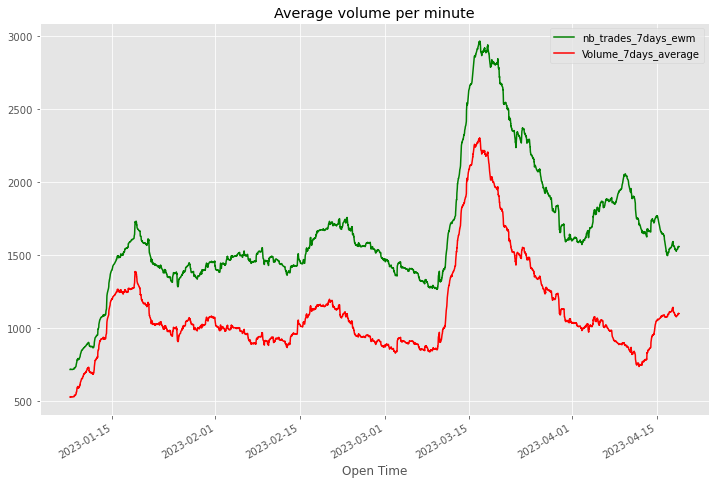

In [93]:
from sklearn.preprocessing import MinMaxScaler
df.nb_trades_7days_ewm.plot(figsize = (12,8), c= "green", title = "Average nb of trades per minute")
df["Volume_7days_average"] = df["Volume"].rolling(window= 480 *7).mean()
df.Volume_7days_average.plot(figsize = (12,8), c= "red", title = "Average volume per minute")
plt.legend()

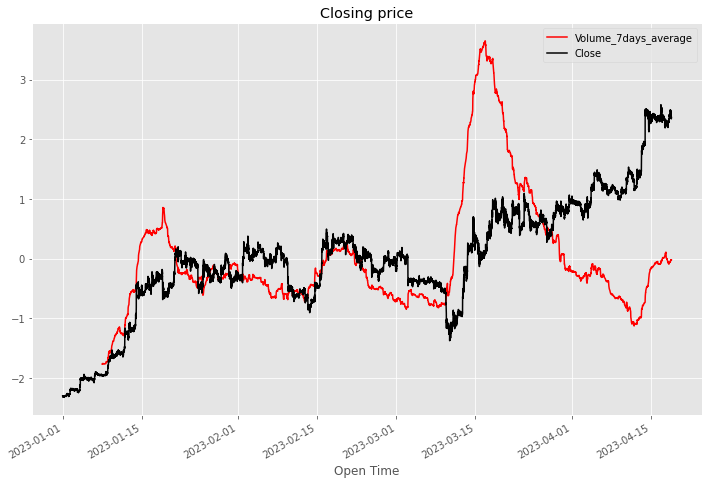

In [94]:
df_norm = (df -df.mean())/df.std()
df_norm.Volume_7days_average.plot(figsize = (12,8), c= "red", title = "Average volume per minute")
df_norm.Close.plot(figsize = (12,8), c= "black", title = "Closing price")
plt.legend()

The 7 days ewm nb of trades variable seems to be highly correlated with the close price.
Trading strategy : Buy/Sell when the nb of trade ewm > 20% as usual and close the position when it comes back to normal.

In [181]:
class backtest():
    
    def __init__(self,df):
        self.df = df
        
    def buy_condition(self,row,previous_row):
        if row["Senkou_Span_A"] > row["Senkou_Span_B"] and previous_row["Senkou_Span_A"] < previous_row["Senkou_Span_B"]:
            return True
        else:
            return False
        
    def sell_condition(self,row,previous_row):
        if row["Senkou_Span_A"] < row["Senkou_Span_B"] and previous_row["Senkou_Span_A"] > previous_row["Senkou_Span_B"]:
            return True
        else:
            return False
        
    def backtest_ichimoku(self,df,initial_balance):
        df_backtest = df.copy()
        open_position = False
        wallet_value = initial_balance
        PnLs = []
        capital_returns = []
        previous_row = df_backtest.iloc[0]
        
        for index, row in df.iterrows():
            if not open_position:
                if self.buy_condition(row,previous_row) == True:
                    buy_price = row.Close
                    open_position == True
                    
            if open_position == True:
                if self.sell_condition(row,previous_row) == True:
                    print(row)
                    sell_price = row.Close
                    PnL = (sell_price - buy_price) 
                    PnLs.append(PnL)
                    capital_return = (sell_price - buy_price)/buy_price
                    capital_returns.append(capital_return)
                    open_position = False
            previous_row = row 
        total_return = (pd.Series(capital_returns) + 1).prod()
        return total_return     
        
        
   

df_ichimoku = data.get_historical_data("BTCUSDT","01-01-2020","1DAY",log_returns=False)
indicators = trading_indicators(df_ichimoku)
indicators.ichimoku(df_ichimoku)
backtest = backtest(df_ichimoku)
backtest.backtest_ichimoku(df_ichimoku,100)

C:\Users\ernes\AppData\Local\Temp/ipykernel_12144/2679011228.py:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  total_return = (pd.Series(capital_returns) + 1).prod()


1.0

Period : [2023-01-01 00:00:00] -> [2023-04-18 15:51:00]
Starting balance : 100 $
Final balance : 101.38 $
Performance vs US Dollar : 1.38 %
Buy and Hold Performence : 75.19 %
Performance vs Buy and Hold : -98.17 %
Number of negative trades :  15
Number of positive trades :  10
Average Positive Trades :  1.1 %
Average Negative Trades :  -0.52 %
Best trade +1.95 %, the  2023-03-10 13:48:00
Worst trade -0.55 %, the  2023-01-04 15:00:00
Worst drawBack -2.0 %
Total fee :  3.17 $
Volume upside trend number : 25
Sell Stop Loss number : 14
Volume downside trend number : 8
Sell Take Profit number : 3


,date,position,reason,price,fees,fiat,coins,wallet,drawBack,PnL,PnL%,tradeIs
0,2023-01-04 03:06:00,Buy,Volume upside trend,1251.33000,0.070000,0,0.079859,99.930000,0.000000,NaN,NaN,
1,2023-01-04 15:00:00,Sell,Sell Stop Loss,1245.07335,0.049715,99.380635,0.000000,99.380635,-0.005498,-0.549365,-0.549750,Bad
2,2023-01-12 17:36:00,Buy,Volume upside trend,1419.36000,0.069566,0,0.069969,99.311068,-0.006194,NaN,NaN,
3,2023-01-13 00:12:00,Sell,Sell Stop Loss,1412.26320,0.049407,98.765106,0.000000,98.765106,-0.011657,-0.545963,-0.549750,Bad
4,2023-01-16 08:09:00,Buy,Volume upside trend,1537.75000,0.069136,0,0.064182,98.695970,-0.012349,NaN,NaN,
5,2023-01-16 15:12:00,Sell,Sell Stop Loss,1530.06125,0.049101,98.153389,0.000000,98.153389,-0.017779,-0.542581,-0.549750,Bad
6,2023-01-23 14:57:00,Buy,Volume upside trend,1599.13000,0.068707,0,0.061336,98.084682,-0.018466,NaN,NaN,
7,2023-01-23 15:00:00,Sell,Volume downside trend,1614.26000,0.069309,98.943391,0.000000,98.943391,-0.009873,0.858709,0.875477,Good
8,2023-01-24 22:27:00,Buy,Volume upside trend,1546.09000,0.069260,0,0.063951,98.874130,-0.010566,NaN,NaN,
9,2023-01-24 22:30:00,Sell,Volume downside trend,1562.87000,0.069963,99.877266,0.000000,99.877266,-0.000528,1.003136,1.014559,Good


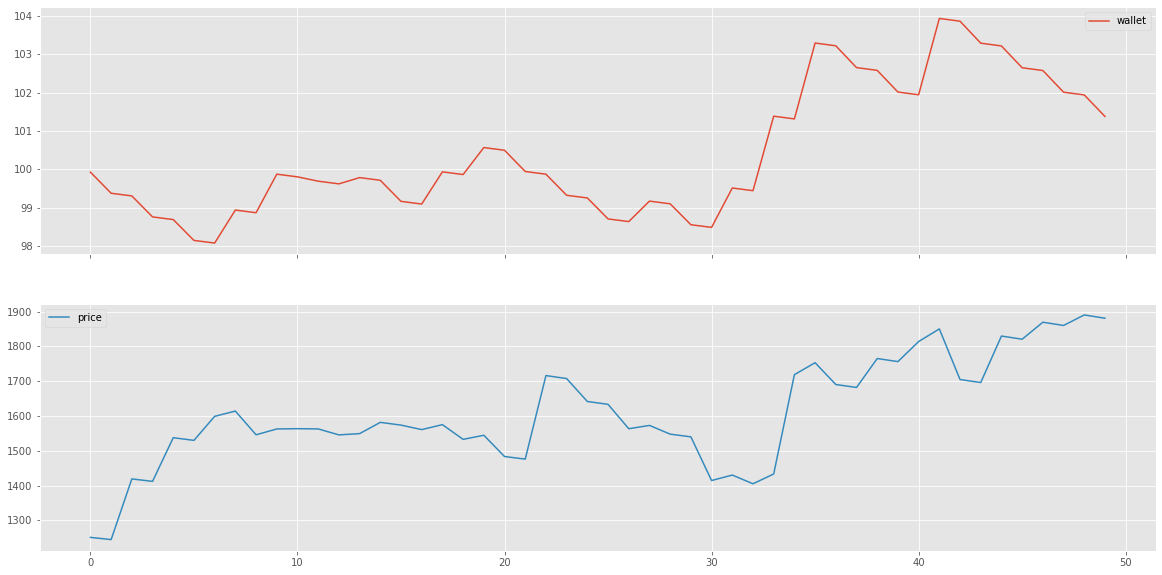

In [146]:
def buyCondition(row, previousrow, qty):
  if row["Number of Trades"] > qty :
    return True
  else:
    return False


def sellCondition(row, previousrow,qty):
  if row["Number of Trades"] > qty  and previousrow["Simple_returns"] < -0.01 :
    return True
  else:
    return False


def backtest(starting_balance,stop_loss,take_profit,makerFee = 0.0005,takerFee = 0.0007,graph = True, dataset = True):
    global trade_table
    
    df_trade = df.copy()
    trade_table = None
    trade_table = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'fees' ,'fiat', 'coins', 'wallet', 'drawBack'])
    usdt = starting_balance
    initalWallet = usdt
    coin = 0
    wallet = 1000
    lastAth = 0
    previousrow = df_trade.iloc[0]
    stopLoss = 0
    takeProfit= math.inf
    

    buyReady = True
    sellReady = True


    for index, row in df_trade.iterrows():
      #Buy market order
      if buyCondition(row, previousrow,20000) == True and usdt > 0 and buyReady == True:
        #buy at close
        buyPrice = row['Close']

        #Define the price of you SL and TP or comment it if you don't want a SL or TP
        stopLoss = buyPrice * (1 - stop_loss) 
        takeProfit = buyPrice * (1 + take_profit) 

        coin = usdt / buyPrice
        fee = takerFee * coin
        coin = coin - fee
        usdt = 0
        wallet = coin * buyPrice
        if wallet > lastAth:
          lastAth = wallet

        myrow = {'date': index,'position': "Buy", 'reason': 'Volume upside trend','price': buyPrice,'fees': fee*buyPrice,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
        trade_table = trade_table.append(myrow, ignore_index = True)

      #Stop Loss
      elif row['Low'] < stopLoss and coin > 0:

        sellPrice = stopLoss

        usdt = coin * sellPrice
        fee = makerFee * usdt
        usdt = usdt - fee
        coin = 0
        buyReady = False
        wallet = usdt
        if wallet > lastAth:
          lastAth = wallet

        myrow = {'date': index,'position': "Sell", 'reason': 'Sell Stop Loss', 'price': sellPrice, 'fees': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
        trade_table = trade_table.append(myrow,ignore_index=True)

      #Take Profit
      elif row['High'] > takeProfit and coin > 0:

        sellPrice = takeProfit

        usdt = coin * sellPrice
        fee = makerFee * usdt
        usdt = usdt - fee
        coin = 0
        buyReady = False
        wallet = usdt
        if wallet > lastAth:
          lastAth = wallet

        myrow = {'date': index,'position': "Sell", 'reason': 'Sell Take Profit', 'price': sellPrice, 'fees': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
        trade_table = trade_table.append(myrow,ignore_index=True)     

      # Sell Market
      elif sellCondition(row, previousrow,2) == True:
        buyReady = True
        if coin > 0 and sellReady == True:
          sellPrice = row['Close']
          usdt = coin * sellPrice
          frais = takerFee * usdt
          usdt = usdt - frais
          coin = 0
          wallet = usdt
          if wallet > lastAth:
            lastAth = wallet

          myrow = {'date': index,'position': "Sell", 'reason': 'Volume downside trend', 'price': sellPrice, 'fees': frais, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
          trade_table = trade_table.append(myrow,ignore_index=True)

      previousrow = row
        

    #///////////////////////////////////////
    print("Period : [" + str(df_trade.index[0]) + "] -> [" +str(df_trade.index[len(df_trade)-1]) + "]")
    trade_table['PnL'] = trade_table['wallet'].diff()
    trade_table['PnL%'] = trade_table['wallet'].pct_change()*100
    trade_table.loc[trade_table['position'] =='Buy','PnL'] = None
    trade_table.loc[trade_table['position'] =='Buy','PnL%'] = None

    trade_table['tradeIs'] =""
    trade_table.loc[trade_table['PnL']>0,'tradeIs'] = 'Good'
    trade_table.loc[trade_table['PnL']<=0,'tradeIs'] = 'Bad'

    iniClose = df_trade.iloc[0]['Close']
    lastClose = df_trade.iloc[len(df_trade)-1]['Close']
    holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
    algoPorcentage = ((wallet - starting_balance)/starting_balance) * 100
    vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100
    print(f"Starting balance : {starting_balance} $")
    print("Final balance :",round(wallet,2),"$")
    print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
    print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
    print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
    print("Number of negative trades : ",trade_table.groupby('tradeIs')['date'].nunique()['Bad'])
    print("Number of positive trades : ",trade_table.groupby('tradeIs')['date'].nunique()['Good'])
    print("Average Positive Trades : ",round(trade_table.loc[trade_table['tradeIs'] == 'Good', 'PnL%'].sum()/trade_table.loc[trade_table['tradeIs'] == 'Good', 'PnL%'].count(),2),"%")
    print("Average Negative Trades : ",round(trade_table.loc[trade_table['tradeIs'] == 'Bad', 'PnL%'].sum()/trade_table.loc[trade_table['tradeIs'] == 'Bad', 'PnL%'].count(),2),"%")
    idbest = trade_table.loc[trade_table['tradeIs'] == 'Good', 'PnL%'].idxmax()
    idworst = trade_table.loc[trade_table['tradeIs'] == 'Bad', 'PnL%'].idxmin()
    print("Best trade +"+str(round(trade_table.loc[trade_table['tradeIs'] == 'Good', 'PnL%'].max(),2)),"%, the ",trade_table['date'][idbest])
    print("Worst trade",round(trade_table.loc[trade_table['tradeIs'] == 'Bad', 'PnL%'].min(),2),"%, the ",trade_table['date'][idworst])
    print("Worst drawBack", str(100*round(trade_table['drawBack'].min(),2)),"%")
    print("Total fee : ",round(trade_table['fees'].sum(),2),"$")
    reasons = trade_table['reason'].unique()
    for r in reasons:
      print(r+" number :",trade_table.groupby('reason')['date'].nunique()[r])
    if graph == True :
        trade_table[['wallet','price']].plot(subplots=True, figsize=(20,10))
    if dataset == True :
        return  trade_table
    
backtest(100,0.005,0.02,makerFee = 0.0005,takerFee = 0.0007,graph = True, dataset = True)


In [177]:
index_buys = trade_table.loc[trade_table["position"]=="Buy","date"]
buy_prices = trade_table.loc[trade_table["position"]=="Buy","price"]
index_sells = trade_table.loc[trade_table["position"]=="Sell","date"]
sell_prices = trade_table.loc[trade_table["position"]=="Sell","price"]


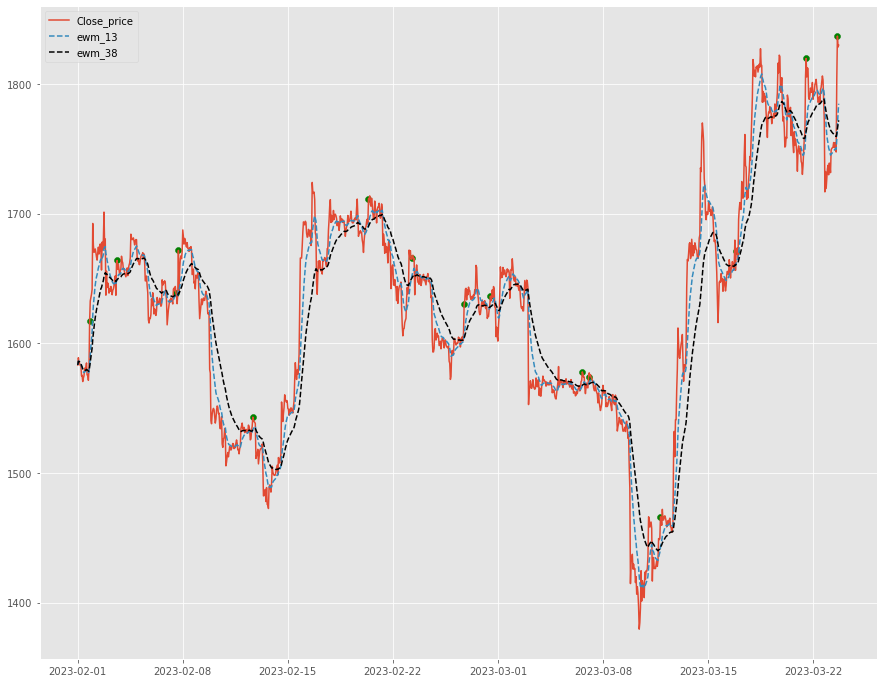

In [187]:
df_trade = df
plt.figure(figsize =(15,12))
plt.plot(df_trade.index, df_trade['Close'],label="Close_price")
plt.plot(df_trade.index, df_trade['EWMA_13'], "--",label="ewm_13")
plt.plot(df_trade.index, df_trade['EWMA_38'], "--",label="ewm_38", color ="black")
plt.scatter(index_buys,buy_prices, color = "green")
plt.legend()


# Fear and greed backtest

In [1]:
from datetime import datetime
import dateparser
start_df = get_historical_data("ETHUSDT","01-01-2022","1DAY",log_returns=True)
start_df["date"] = start_df.index
start_df = start_df.set_index("date")

NameError: name 'get_historical_data' is not defined

<AxesSubplot:xlabel='date'>

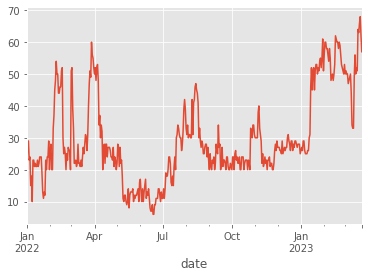

In [365]:
def fear_and_greed_index(data):
    global  fear
    response = requests.get("https://api.alternative.me/fng/?limit=0&format=json")
    dataResponse = response.json()['data']
    fear = pd.DataFrame(dataResponse, columns = ['timestamp', 'value'])
    fear = fear.rename(columns = {"timestamp":"date"})
    fear["date"] = fear["date"].map(lambda x : datetime.fromtimestamp(int(x))).map(lambda x : datetime.strftime(x,"%Y-%m-%d"))
    fear["date"] = pd.to_datetime(fear["date"])
    fear = fear.set_index("date")
    fear["value"] = pd.to_numeric(fear["value"])
    df =  pd.merge(data, fear, left_index=True, right_index=True)
    df.rename(columns={"value":"Fear_and_greed"},inplace = True)
    return df
df = fear_and_greed_index(start_df)
df.Fear_and_greed.plot()

In [360]:
#def of the strategy : as soon as we are in extrem greed we sell
# as soon as we are in extrem fear we sell

def buyCondition(row, previousrow):
  if previousrow["Fear_and_greed"] > 30 and row["Fear_and_greed"] < 30:
    return True
  else:
    return False


def sellCondition(row, previousrow):
  if previousrow["Fear_and_greed"] < 70 and row["Fear_and_greed"] > 70:
    return True
  else:
    return False

In [3]:
def backtest(starting_balance,stop_loss,take_profit,makerFee = 0.0005,takerFee = 0.0007, graph = True, dataset = True):
    global trade_table,df_trade
    
    df_trade = df.copy()
    trade_table = None
    trade_table = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'fees' ,'fiat', 'coins', 'wallet', 'drawBack'])
    usdt = starting_balance
    initalWallet = usdt
    coin = 0
    wallet = 1000
    lastAth = 0
    previousrow = df_trade.iloc[0]
    stopLoss = 0
    takeProfit= math.inf
    

    buyReady = True
    sellReady = True


    for index, row in df_trade.iterrows():
      #Buy market order
      if buyCondition(row, previousrow) == True and usdt > 0 and buyReady == True:
        #buy at close
        buyPrice = row['Close']

        #Define the price of you SL and TP or comment it if you don't want a SL or TP
        stopLoss = buyPrice * (1 - stop_loss) 
        takeProfit = buyPrice * (1 + take_profit) 

        coin = usdt / buyPrice
        fee = takerFee * coin
        coin = coin - fee
        usdt = 0
        wallet = coin * buyPrice
        buyReady = False
        if wallet > lastAth:
          lastAth = wallet

        myrow = {'date': index,'position': "Buy", 'reason': 'Too much fear','price': buyPrice,'fees': fee*buyPrice,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
        trade_table = trade_table.append(myrow, ignore_index = True)

      #Stop Loss
      elif row['Low'] < stopLoss and coin > 0:

        sellPrice = stopLoss

        usdt = coin * sellPrice
        fee = makerFee * usdt
        usdt = usdt - fee
        coin = 0
        buyReady = True
        wallet = usdt
        if wallet > lastAth:
          lastAth = wallet

        myrow = {'date': index,'position': "Sell", 'reason': 'Sell Stop Loss', 'price': sellPrice, 'fees': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
        trade_table = trade_table.append(myrow,ignore_index=True)

      #Take Profit
      elif row['High'] > takeProfit and coin > 0:

        sellPrice = takeProfit

        usdt = coin * sellPrice
        fee = makerFee * usdt
        usdt = usdt - fee
        coin = 0
        buyReady = True
        wallet = usdt
        if wallet > lastAth:
          lastAth = wallet

        myrow = {'date': index,'position': "Sell", 'reason': 'Sell Take Profit', 'price': sellPrice, 'fees': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
        trade_table = trade_table.append(myrow,ignore_index=True)     

      # Sell Market
      elif sellCondition(row, previousrow) == True:
        buyReady = True
        if coin > 0 and sellReady == True:
          sellPrice = row['Close']
          usdt = coin * sellPrice
          frais = takerFee * usdt
          usdt = usdt - frais
          coin = 0
          wallet = usdt
          if wallet > lastAth:
            lastAth = wallet

          myrow = {'date': index,'position': "Sell", 'reason': 'Too much greed', 'price': sellPrice, 'fees': frais, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
          trade_table = trade_table.append(myrow,ignore_index=True)

      previousrow = row
    return trade_table
    
backtest(100,0.1,0.2,makerFee = 0.0005,takerFee = 0.0007,graph = True, dataset = True)


NameError: name 'df' is not defined

# Triangular arbitrage

In [4]:
class crypto_triangular_arbitrage:
    
    def __init__(self,starting_coin):
        self.starting_coin = starting_coin
        
    def get_tickers(self,starting_coin, dataset = False):
        pair_2 = []
        pair_3 = []
        database = pd.DataFrame(client.get_all_tickers())
        tickers = database.symbol
        for ticker in tickers :
            if self.starting_coin in ticker and "USDT" not in ticker:
                pair_2.append(ticker)

        for ticker_2 in pair_2:
            foreing_cur = ticker_2.replace(self.starting_coin,"")
            pair_3.append(foreing_cur +"USDT")
                          
        Tickers = [pair_2,pair_3]
        flattened = [val for sublist in Tickers for val in sublist]
        Tickers = flattened
        return Tickers
                          
    def arbitrage_df(self,available_Tickers):
        global arbitrage_df
        pair_2 = []
        pair_3 = []
                           
        arbitrage_df = pd.DataFrame(columns = ["Asset_1","Asset_2","Asset_3"])
        for ticker in available_Tickers :
            if self.starting_coin in ticker and "USDT" not in ticker:
                pair_2.append(ticker)

        for ticker_2 in pair_2:
            foreing_cur = ticker_2.replace(self.starting_coin,"")
            pair_3.append(foreing_cur +"USDT")

        pair_1 = [self.starting_coin + "USDT"] * len(pair_2)
        arbitrage_df.Asset_1 = pair_1
        arbitrage_df.Asset_2 = pair_2
        arbitrage_df.Asset_3 = pair_3
                          
        return arbitrage_df
        
        
    def get_historical_data(self,pair,start_date,timeframe,log_returns=False):
        global df_historical_data
        command = "Client.KLINE_INTERVAL_{}".format(timeframe)
        try :
            historical_data = client.get_historical_klines(str(pair),eval(command),str(start_date))
        except BaseException:
            return
        df_historical_data = pd.DataFrame(historical_data)
        try :
            df_historical_data.columns =  ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                            'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
        except BaseException:
            return
        df_historical_data['Open Time'] = pd.to_datetime(df_historical_data['Open Time']/1000, unit='s')
        df_historical_data['Close Time'] = pd.to_datetime(df_historical_data['Close Time']/1000, unit='s')
        df_historical_data = df_historical_data[['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Number of Trades']]
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Number of Trades']
        df_historical_data[numeric_columns]=df_historical_data[numeric_columns].apply(pd.to_numeric, axis=1)
        df_historical_data["Simple_returns"] = df_historical_data["Close"].pct_change()
        df_historical_data.set_index("Open Time", inplace =True)
    
        if log_returns == True:
            df_historical_data["log_returns"] = [np.log(rt +1) for rt in  df_historical_data["Simple_returns"]]

        return df_historical_data
    
    def multiple_historical_data(self,Tickers,start_date,timeframe):
        global data
        df={}
        data = pd.DataFrame()
        for ticker in Tickers:
            try :
                df[f"{ticker}"] = self.get_historical_data(ticker,start_date,timeframe)
            except BaseException:
                print(f"{ticker} not recognized by the Binance API")
                pass
            
            try:
                if df[f"{ticker}"] is None :
                    pass
            except BaseException:
                pass

            try:
                if df[f"{ticker}"].empty == False:
                    df[f"{ticker}"] = df_historical_data["Close"]
                    data[f"{ticker}"] = df[f"{ticker}"]
            except BaseException:
                pass

        check_for_nan = data.isnull().sum()
        print("NaN values found:")
        print(check_for_nan)
        data = data.dropna(axis=1)
        data = data.sort_values(by="Open Time")
        return data
    
    def check_triangular_arbitrage(self,fees,starting_balance,arbitrage_df,data):
        global Total_PnL_comination
        all_df = {}
        Total_PnL_combination = {}
        trade_table = pd.DataFrame(columns = ["Date","PnL"])
        for i  in range(len(arbitrage_df)):
            Tickers = arbitrage_df.iloc[i].values
            ticker_1 = Tickers[0]
            ticker_2 = Tickers[1]
            ticker_3 = Tickers[2]
            if ticker_1 not in data.columns or ticker_2 not in data.columns or ticker_3 not in data.columns :
                continue

            for index, row in data.iterrows():
                amount_coin_1 = starting_balance / row[Tickers[0]]
                amount_coin_1 = amount_coin_1 * (1-fees)
                amount_coin_2 = amount_coin_1 / row[Tickers[1]]
                amount_coin_2 = amount_coin_2 * (1-fees)
                amount_usdt = amount_coin_2 * row[Tickers[2]]
                amount_usdt = amount_usdt * (1-fees)
                if amount_usdt > starting_balance :
                    short_date = index.strftime('%Y-%m-%d')
                    PnL = amount_usdt - starting_balance
                    print(f"Triangular arbitrage found the {short_date} for {ticker_1}=>{ticker_2}=>{ticker_3}, profit= {PnL}")
                    trade_table = trade_table.append({"Date":index,"PnL":PnL},ignore_index = True)
            
            all_df[f"{Tickers}"] = trade_table
            Total_PnL_combination[f"{Tickers}"] = np.sum(trade_table.PnL)

     
    
    
test = crypto_triangular_arbitrage("BTC")
Tickers = test.get_tickers(test.starting_coin)
Tickers.append("BTCUSDT")
data =  test.multiple_historical_data(Tickers,"2023-01-01","1DAY")
available_Tickers = data.columns.to_list()
arbitrage_df = test.arbitrage_df(available_Tickers)
test.check_triangular_arbitrage(0.00075,1000,arbitrage_df,data)



      




C:\Users\ernes\AppData\Local\Temp/ipykernel_11564/4047438116.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{ticker}"] = df[f"{ticker}"]


NaN values found:
ETHBTC       0
LTCBTC       0
BNBBTC       0
NEOBTC       0
GASBTC       0
            ..
LQTYUSDT    58
IDUSDT      80
ARBUSDT     81
RDNTUSDT    88
BTCUSDT      0
Length: 621, dtype: int64
Triangular arbitrage found the 2023-01-07 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 0.7695534334035301
Triangular arbitrage found the 2023-01-23 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 0.6472063416075571
Triangular arbitrage found the 2023-01-24 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 0.27191082776130315
Triangular arbitrage found the 2023-01-27 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 0.10104521849359571
Triangular arbitrage found the 2023-03-13 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 0.10298249265360937
Triangular arbitrage found the 2023-03-14 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 1.9490316092526427
Triangular arbitrage found the 2023-03-28 for BTCUSDT=>NEOBTC=>NEOUSDT, profit= 1.1836098997817999
Triangular arbitrage found the 2023-01-03 for BTCUSDT=>WTCBTC=>WTCUSDT, profit= 1.3126724306721

# Arbitrage trading strategy with manual API requests

In [134]:
Tickers = ["BTCUSDT","ETHBTC","ETHUSDT"]
Asset = ["USDT","BTC","BNB"]


class arbitrage:
    
    secret_pharse = ""
    API_key = ""

    client = Client(API_key,secret_pharse)
    
    def __init__(self,Tickers):
        pd.options.display.float_format = '{:.9f}'.format
        self.tickers = Tickers
        
    
    def bid_ask_wall(self,ticker,nb_rows):
        global df_wall_ask, df_wall_bid
        bloc = self.client.get_order_book(symbol = ticker)
        df_wall_ask = pd.DataFrame(bloc["asks"])
        df_wall_ask.columns = ["Ask","Volume_ask"]
        df_wall_bid = pd.DataFrame(bloc["bids"])
        df_wall_bid.columns = ["Bid" ,"Volume_bid"]
        bid_ask_df = pd.concat([df_wall_bid,df_wall_ask], axis=1)
        bid_ask_df = bid_ask_df.astype(float)
        bid_ask_df["Spread"] = bid_ask_df["Ask"] - bid_ask_df["Bid"]
        bid_ask_df["Mid_point"] = (bid_ask_df["Ask"] + bid_ask_df["Bid"])/2
        bid_ask_df["Relative_Spread"] = bid_ask_df["Spread"] /  bid_ask_df["Mid_point" ]
        return bid_ask_df.iloc[-nb_rows:]

    def possible_arbitrage(self,Tickers,initial_amount,fees = 0.00075):
        
        df =  pd.DataFrame()
        for ticker in Tickers:
            row = self.bid_ask_wall(ticker,1)
            df = df.append(row)

        amount_coin_1 = initial_amount / df.iloc[0].Ask
        amount_coin_1 = amount_coin_1 * (1-fees)

        if amount_coin_1 / df.iloc[1].Ask <= df.iloc[1].Volume_ask:
            amount_coin_2 = amount_coin_1 / df.iloc[1].Ask
        else:
            return f"Volumes were not large enough for {Tickers[1]}"
 
        amount_coin_2 = amount_coin_2 * (1-fees)
    
        if amount_coin_2 / df.iloc[2].Bid <= df.iloc[2].Volume_bid:
            amount_usdt = amount_coin_2 * df.iloc[2].Bid
            amount_usdt = amount_usdt * (1-fees)
        else:
            return f"Volumes were not large enough for {Tickers[2]}"
    
        return float(amount_usdt)
    
    
class trading:
    
    secret_pharse = ""
    API_key = ""

    client = Client(API_key,secret_pharse)
    
        
    def get_balance(self,coin):
        info = client.get_account()
        info = info["balances"]
        df = pd.DataFrame(info)
        coin_amount = df[df.asset == coin].free.values
        coin_amount = float(coin_amount[0])
        return coin_amount

    def price_token(self,pair):
        tickers = client.get_all_tickers()
        df_tickers = pd.DataFrame(tickers)
        df_tickers.set_index("symbol",inplace=True)

        df = df_tickers.loc[str(pair)].iloc[0]
        return float(df)

    def market_order(self,pair,side,qty):
        return client.create_order(symbol = pair, side = side, type = "MARKET", quantity = qty)
    
    
    def triangular_arbitrage(self,Tickers, initial_amount,fees = 0.00075):
        arbitrage_instance = arbitrage(Tickers)
        PnL = arbitrage_instance.possible_arbitrage(Tickers,initial_amount,fees)
        sequence  = ["BUY","BUY","SELL"]
        count = 0
        fees = 0
        USDT_starting_balance = self.get_balance("USDT")
        
        if type(PnL) !=str :
            for trade_side ,ticker, asset in zip(sequence,Tickers,Asset) :
                if count == 0 :
                    qty = round(initial_amount/self.price_token(ticker),4)
                    print(f"{qty} {ticker} bought")
                    count += 1
                elif count == 1 :
                    qty = round(self.get_balance(asset) / self.price_token(ticker) - 0.0001,4)
                    print(f"{qty} {ticker} bought")
                    count += 1
                else :
                    qty = round(self.get_balance(asset),4)
                    print(f"{qty} {ticker} sold")
                    count += 1
                order = self.market_order(ticker,trade_side, qty)
                fee = float(order["fills"][0]["commission"])
                fees += self.price_token("BNBUSDT") * fee
        USDT_ending_balance = self.get_balance("USDT") - fees
                
        return f" USDT Starting balance : {USDT_starting_balance} => USDT ending balance : {USDT_ending_balance}. Total fees : {fees}. PnL = {USDT_ending_balance - USDT_starting_balance}"
    
test = arbitrage(Tickers)
test.possible_arbitrage(Tickers, 11,fees = 0.00075)


        

10.941949958789067

# Binance Trading Bot

In [3]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
import sqlalchemy
from binance import ThreadedWebsocketManager

class Pivix_trading_bot:
    
    secret_pharse = ""
    API_key = ""
    client = Client(API_key,secret_pharse)
    
    def __init__(self,pair):
        self.pair = pair
        self.bm = BinanceSocketManager(client)
        self.socket = self.bm.trade_socket(pair)
        #Create a SQL database to store our prices
        self.engine = sqlalchemy.create_engine(f'sqlite:///{self.pair}stream.db')
    
    #Create a dataframe with the date, the price and the name of the asset
    def createframe(msg):
        df = pd.DataFrame([msg])
        df = df.loc[:,['s','E','p']]
        df.columns = ["Symbol","Date","Price"]
        df.Price = pd.to_numeric(df.Price)
        df["Date"] = pd.to_datetime(df.Date, unit ="ms")
        return df
    
    async def start_stream(self):
        while True:
            await self.socket.__aenter__()
            msg = await self.socket.recv()
            frame = createframe(msg)
            frame.to_sql(pair + "stream",engine,if_exists ='append', index = False)
            print(frame)
    
    #Get the amount of crypto available in your account
    def get_balance(coin):
        info = client.get_account()
        info = info["balances"]
        df = pd.DataFrame(info)
        coin_amount = df[df.asset == coin].free.values
        coin_amount = float(coin_amount[0])
        return coin_amount

    def price_token(pair):
        tickers = client.get_all_tickers()
        df_tickers = pd.DataFrame(tickers)
        df_tickers.set_index("symbol",inplace=True)

        df = df_tickers.loc[str(pair)].iloc[0]
        return float(df)

    def market_order(pair,side,qty):
        client.create_order(symbol = pair,
                            side = side,
                            type = "MARKET",
                            quantity = qty)
        
test = Pivix_trading_bot("BTCUSDT")
test.start_stream()
pd.read_sql(test.pair+"stream",test.engine)

C:\Users\ernes\AppData\Local\Temp/ipykernel_2368/715285516.py:60: RuntimeWarning: coroutine 'Pivix_trading_bot.start_stream' was never awaited
  test.start_stream()


,Symbol,Date,Price
0,BTCUSDT,2023-03-25 12:21:51.489,27436.05
1,BTCUSDT,2023-03-25 12:21:51.596,27436.04
2,BTCUSDT,2023-03-25 12:21:51.597,27436.04
3,BTCUSDT,2023-03-25 12:21:51.949,27436.04
4,BTCUSDT,2023-03-25 12:21:52.088,27436.05
...,...,...,...
667,BTCUSDT,2023-03-25 19:11:32.089,27296.09
668,BTCUSDT,2023-03-25 19:13:49.365,27299.59
669,BTCUSDT,2023-03-25 19:14:20.123,27314.25
670,BTCUSDT,2023-03-25 19:15:54.113,27311.48


In [ ]:
bm = BinanceSocketManager(client)
socket = bm.trade_socket('BTCUSDT')
pair = "BTCUSDT"
engine = sqlalchemy.create_engine(f'sqlite:///{pair}stream.db')

def createframe(msg):
    df = pd.DataFrame([msg])
    df = df.loc[:,['s','E','p']]
    df.columns = ["Symbol","Date","Price"]
    df.Price = pd.to_numeric(df.Price)
    df["Date"] = pd.to_datetime(df.Date, unit ="ms")
    return df

while True:
    await socket.__aenter__()
    msg = await socket.recv()
    try:
        
        frame = createframe(msg)
        frame.to_sql(pair+"stream",engine,if_exists ='append', index = False)
        
    except BaseException:
        continue
    
    


In [ ]:
#Create a trending trading strategy
#If the crypto was rising by x% => buy
#Exit when you made 0.15% profit and stoploss of -0.15%

def short_term_momentum_trading_strategy(pair,lookback,qty,threshold,open_position = False):
    while True:
        df = pd.read_sql("BTCUSDTstream",engine)
        price = df.Price.iloc[-1]
        qty = qty / price
        qty = round(qty,5)
        loockbackperiod = df.iloc[-lookback:]
        cumulative_return = (loockbackperiod.Price.pct_change() +1).cumprod() -1
        
        if not open_position and cumulative_return.iloc[-1] > threshold :
            buy_order = market_order(pair,"BUY",qty)
            open_position = True
            print(f"Buy order triggered :\n {buy_order}")
        
        if open_position:
            buy_time = df.loc[df.Date > pd.to_datetime(buy_order["transactTime"], unit = "ms")]
            if len (buy_time) > 1:
                cumulative_return_since_buy = (buy_time.Price.pct_change() +1).cumprod() -1
                last_return = cumulative_return_since_buy.iloc[-1]
                if last_return > threshold or last_return < - threshold :
                    sell_order = market_order(pair,"SELL",qty)
                    print(f"Sell order triggered :\n {sell_order}")
            